# Polyphonic pitch detection with convolutional long short-term memory neural networks
TODO Outline experiment.

In [2]:
import random
import json
import os
import warnings

from IPython.display import display, Audio
import librosa
import matplotlib.pyplot as plt
import mir_eval
import mir_eval.display
import numpy as np
from keras.layers import LSTM, Activation, Convolution1D, Dense, TimeDistributed
from keras.models import Sequential
from keras.preprocessing import sequence
import pretty_midi

warnings.filterwarnings(
    'ignore')  # TODO Remove when librosa.cqt has been updated.

DATA_PATH = '.'
RESULTS_PATH = '.'
SCORE_FILE = 'match_scores.json'


def msd_path(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)


def mp3_path(msd_id):
    """Given an MSD ID, return the path to the corresponding MP3 file."""
    return os.path.join(DATA_PATH, 'lmd_matched_mp3',
                        msd_path(msd_id) + '.mp3')


def midi_path(msd_id, midi_md5, kind='aligned'):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file."""
    # TODO Enums kind: 'matched' or 'aligned'
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind), msd_path(msd_id),
                        midi_md5 + '.mid')

# Load data

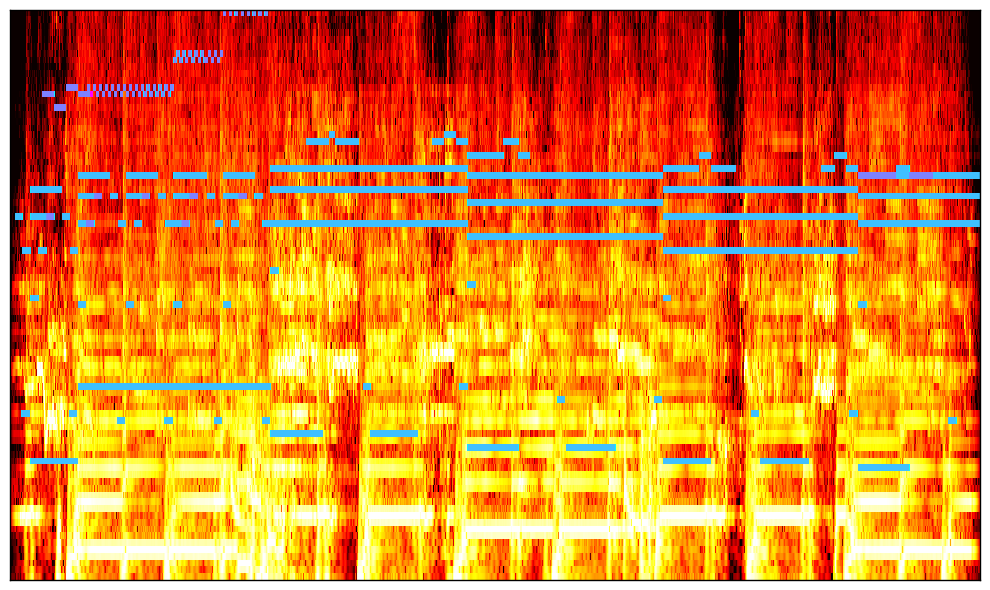

In [6]:
import traceback
from scipy.misc import imresize
with open(SCORE_FILE) as f:
    scores = json.load(f)

def load(msd_id, matches):
    try:
        # Compute constant-Q spectrogram.
        audio, fs = librosa.load(mp3_path(msd_id), sr=None)
        cqt = librosa.logamplitude(librosa.cqt(audio, real=False))
        cqt = librosa.util.normalize(cqt)
        
        # TODO Synthesize MIDI. We could use this for the Lakh MIDI files without 7digital preview MP3s.
        #midi_audio = pm.fluidsynth(fs)
        #display(Audio(midi_audio, rate=fs))
        
        # Average existing MIDI annotations for the audio into a single matrix.
        piano_roll = None
        midi_md5 = max(matches, key=lambda x: x[1])
        """
        for midi_md5, score in matches.items():
            pm = pretty_midi.PrettyMIDI(midi_path(msd_id, midi_md5, 'aligned'))
            x = pm.get_piano_roll()
            if x.shape[1] > 0:
                if piano_roll is not None:
                    x = imresize(x, size=piano_roll.shape)
                    piano_roll = np.dstack((piano_roll, x))
                else:
                    piano_roll = pm.get_piano_roll()[..., np.newaxis]
        """
        pm = pretty_midi.PrettyMIDI(midi_path(msd_id, midi_md5, 'aligned'))
        piano_roll = pm.get_piano_roll()[..., np.newaxis]
        piano_roll = np.average(piano_roll, axis=2)
        
        # Use 7 octaves starting from C1.
        piano_roll = piano_roll[12:96]
        piano_roll = imresize(piano_roll, size=cqt.shape)
        piano_roll = piano_roll.astype(
            np.float) / 255  # Normalize to [0.0, 1.0].
        return cqt, piano_roll
    except Exception as e:
        traceback.print_exc()
        raise e

samples = 100
from multiprocessing import Pool, cpu_count
with Pool(cpu_count()) as p:
    # Grab an MSD ID and its dictionary of matches.
    data = p.starmap(load, [scores.popitem() for _ in range(samples)])

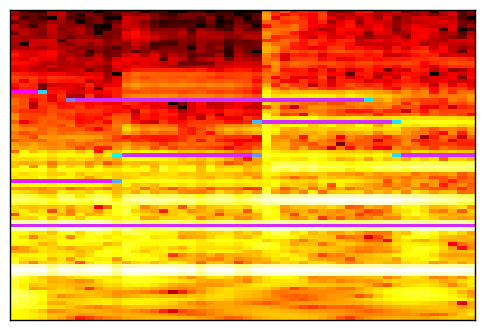

In [42]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

def plot(cqt, piano_roll, dx=50):
    
    def animate(i):
        xs = cqt[..., i:i+dx]
        ys = np.ma.masked_where(piano_roll == 0, piano_roll)[..., i:i+dx]
        return (librosa.display.specshow(xs, cmap=plt.cm.hot), 
                librosa.display.specshow(ys, cmap=plt.cm.cool))
        
    anim = animation.FuncAnimation(plt.figure(), 
                                   animate, 
                                   frames=100, 
                                   interval=20, 
                                   blit=True)
    display(HTML(anim.to_html5_video()))

plot(*data[0])

# Train model

In [ ]:
# Pad audio sequences to length with trailing silence and split into test and training sets.
random.shuffle(data)
flattened = [x for d in data for x in d]
import librosa as lr
padded = [lr.util.fix_length(s, max(x.shape[1] for x in flattened))
          for s in flattened]
# np.expand_dims() TODO Remove.
X = np.dstack(padded[::2]).T
Y = np.dstack(padded[1::2]).T
idx = int(len(X) * 0.9)
X_train, X_test = X[:idx], X[idx:]
Y_train, Y_test = Y[:idx], Y[idx:]

In [ ]:
batch_size = 10
nb_epoch = 10
pitches = Y.shape[-1]
model = Sequential()
model.add(
    Convolution1D(
        input_shape=X[0].shape,
        nb_filter=X[0].shape[0],
        filter_length=10,
        border_mode='same'))
model.add(LSTM(pitches, return_sequences=True))
model.add(TimeDistributed(Dense(pitches, activation='sigmoid')))
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          validation_data=(X_test, Y_test))
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(loss, accuracy)

# Evaluation

In [ ]:
Y_pred = model.predict(X_test, batch_size)
threshold = 0.25
matches = np.count_nonzero((Y_test > 0) & (Y_pred > threshold))
precision = matches / np.count_nonzero(Y_pred)
recall = matches / np.count_nonzero(Y_test)
print("Precision: {}, Recall: {}".format(precision, recall))